# Distance traveled and amount of interactions

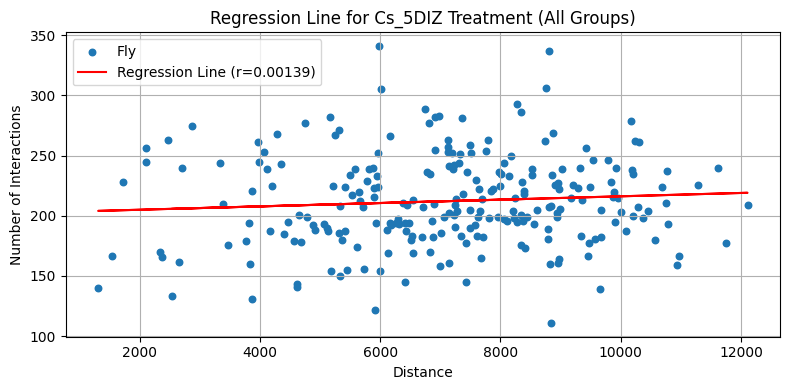

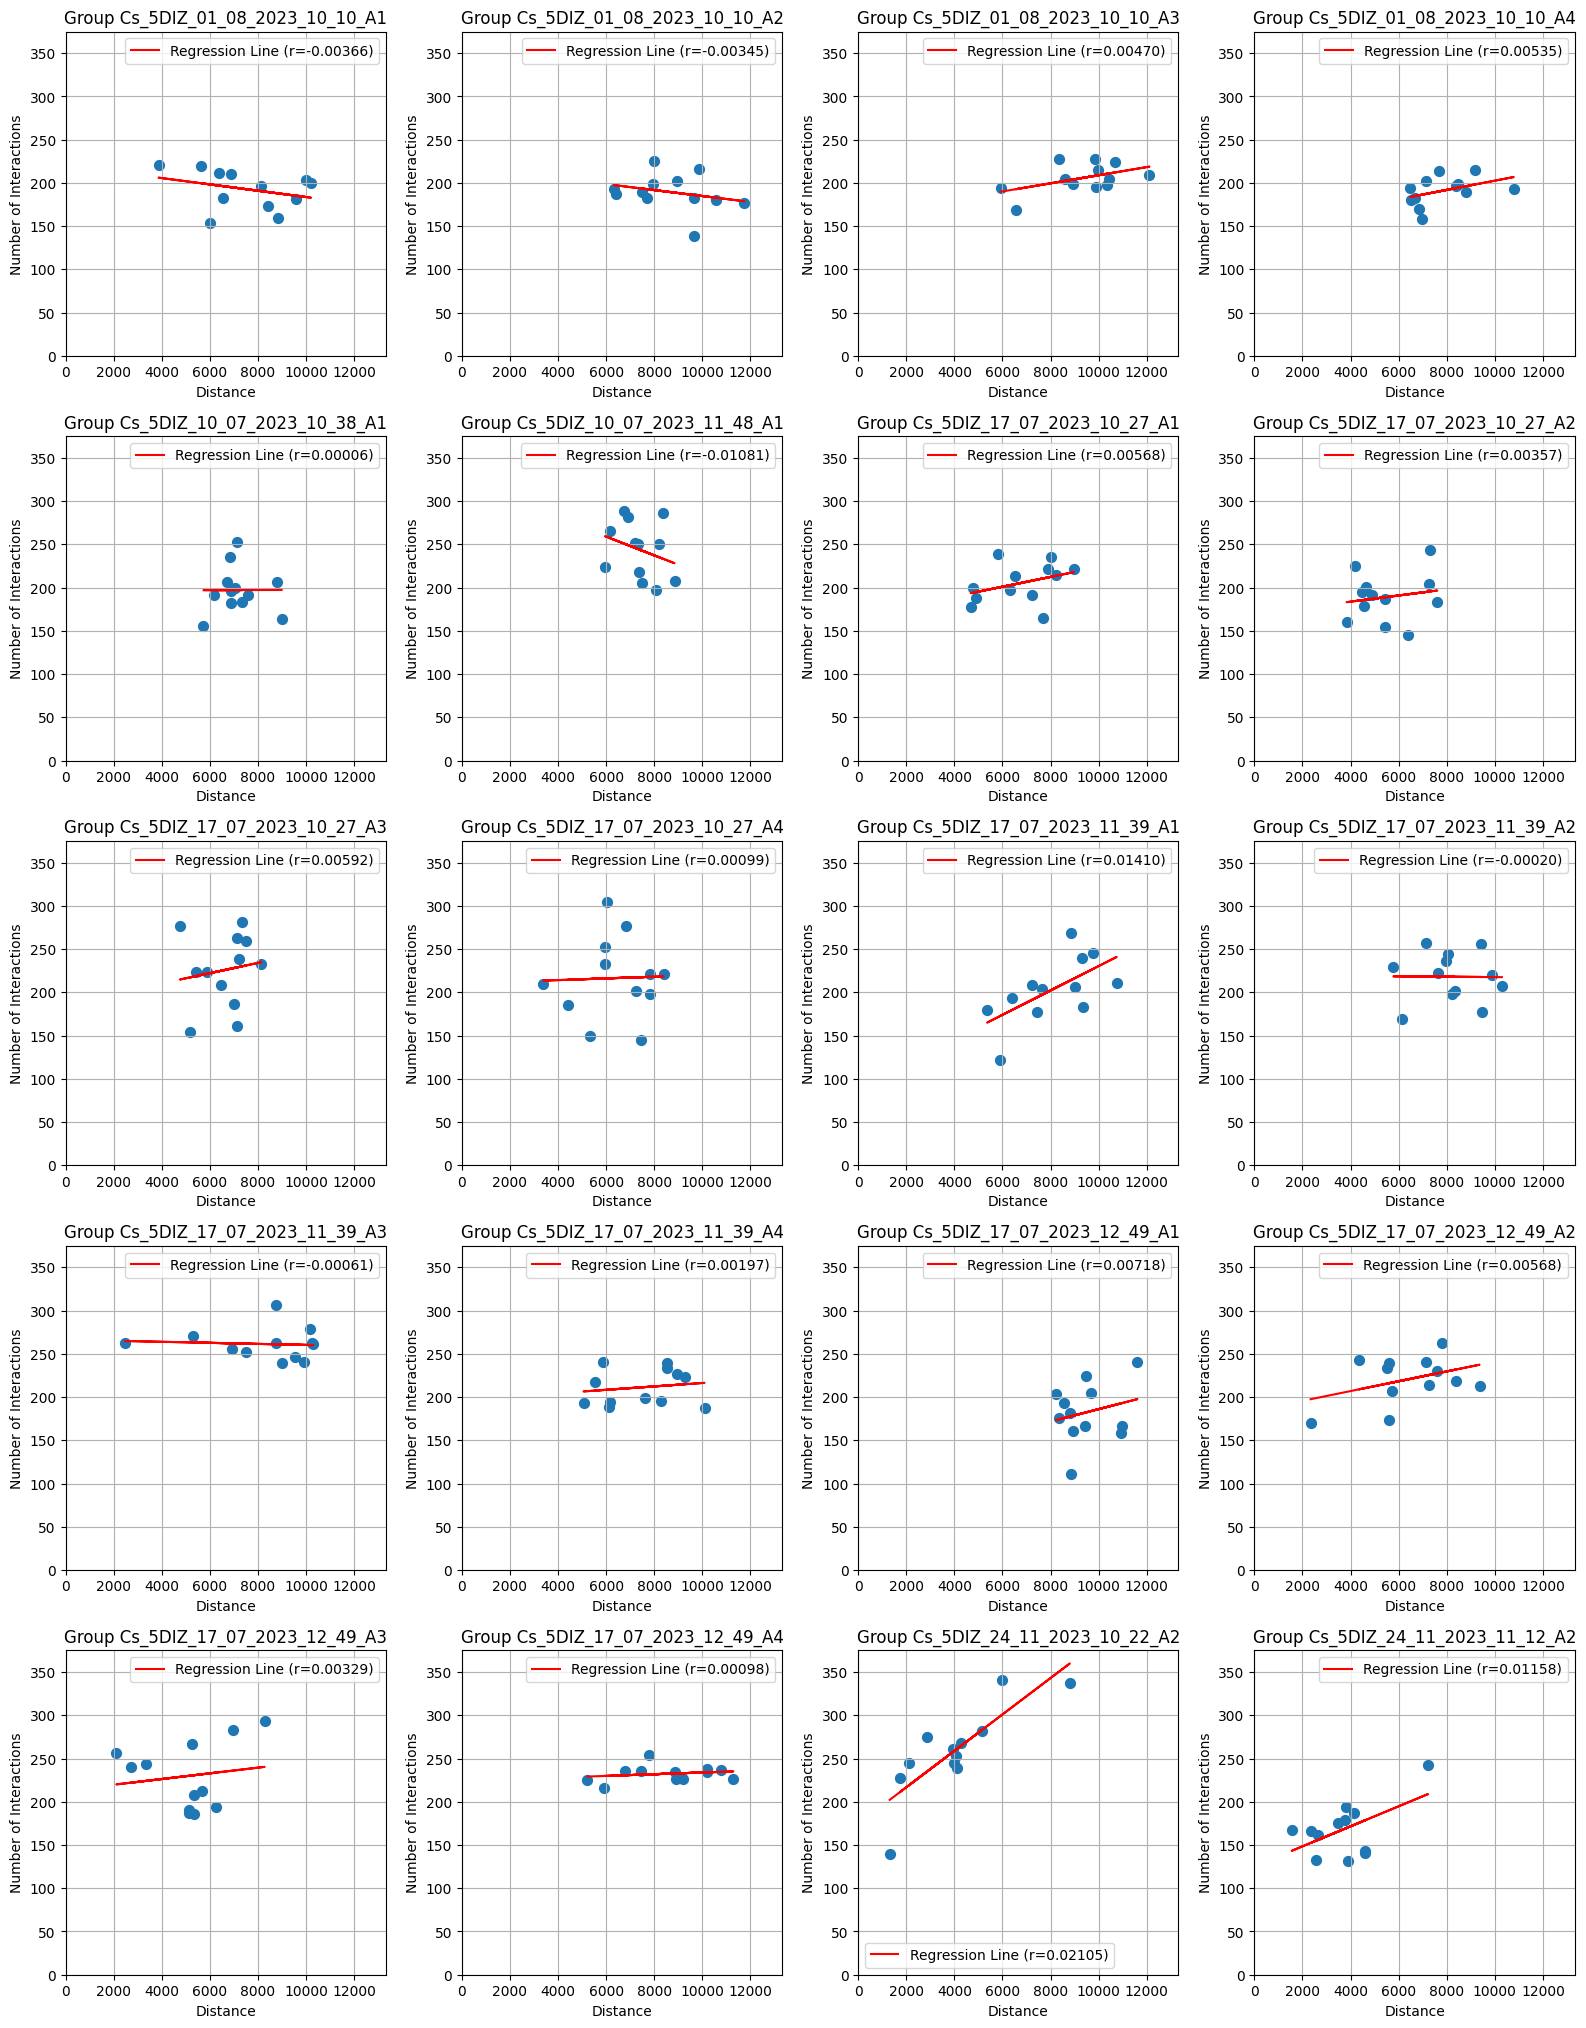

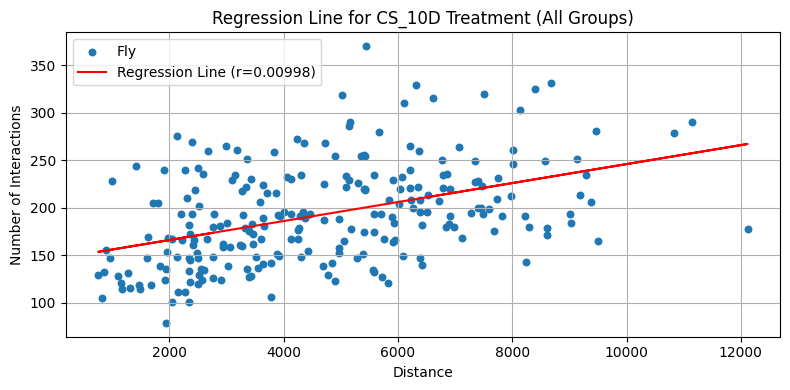

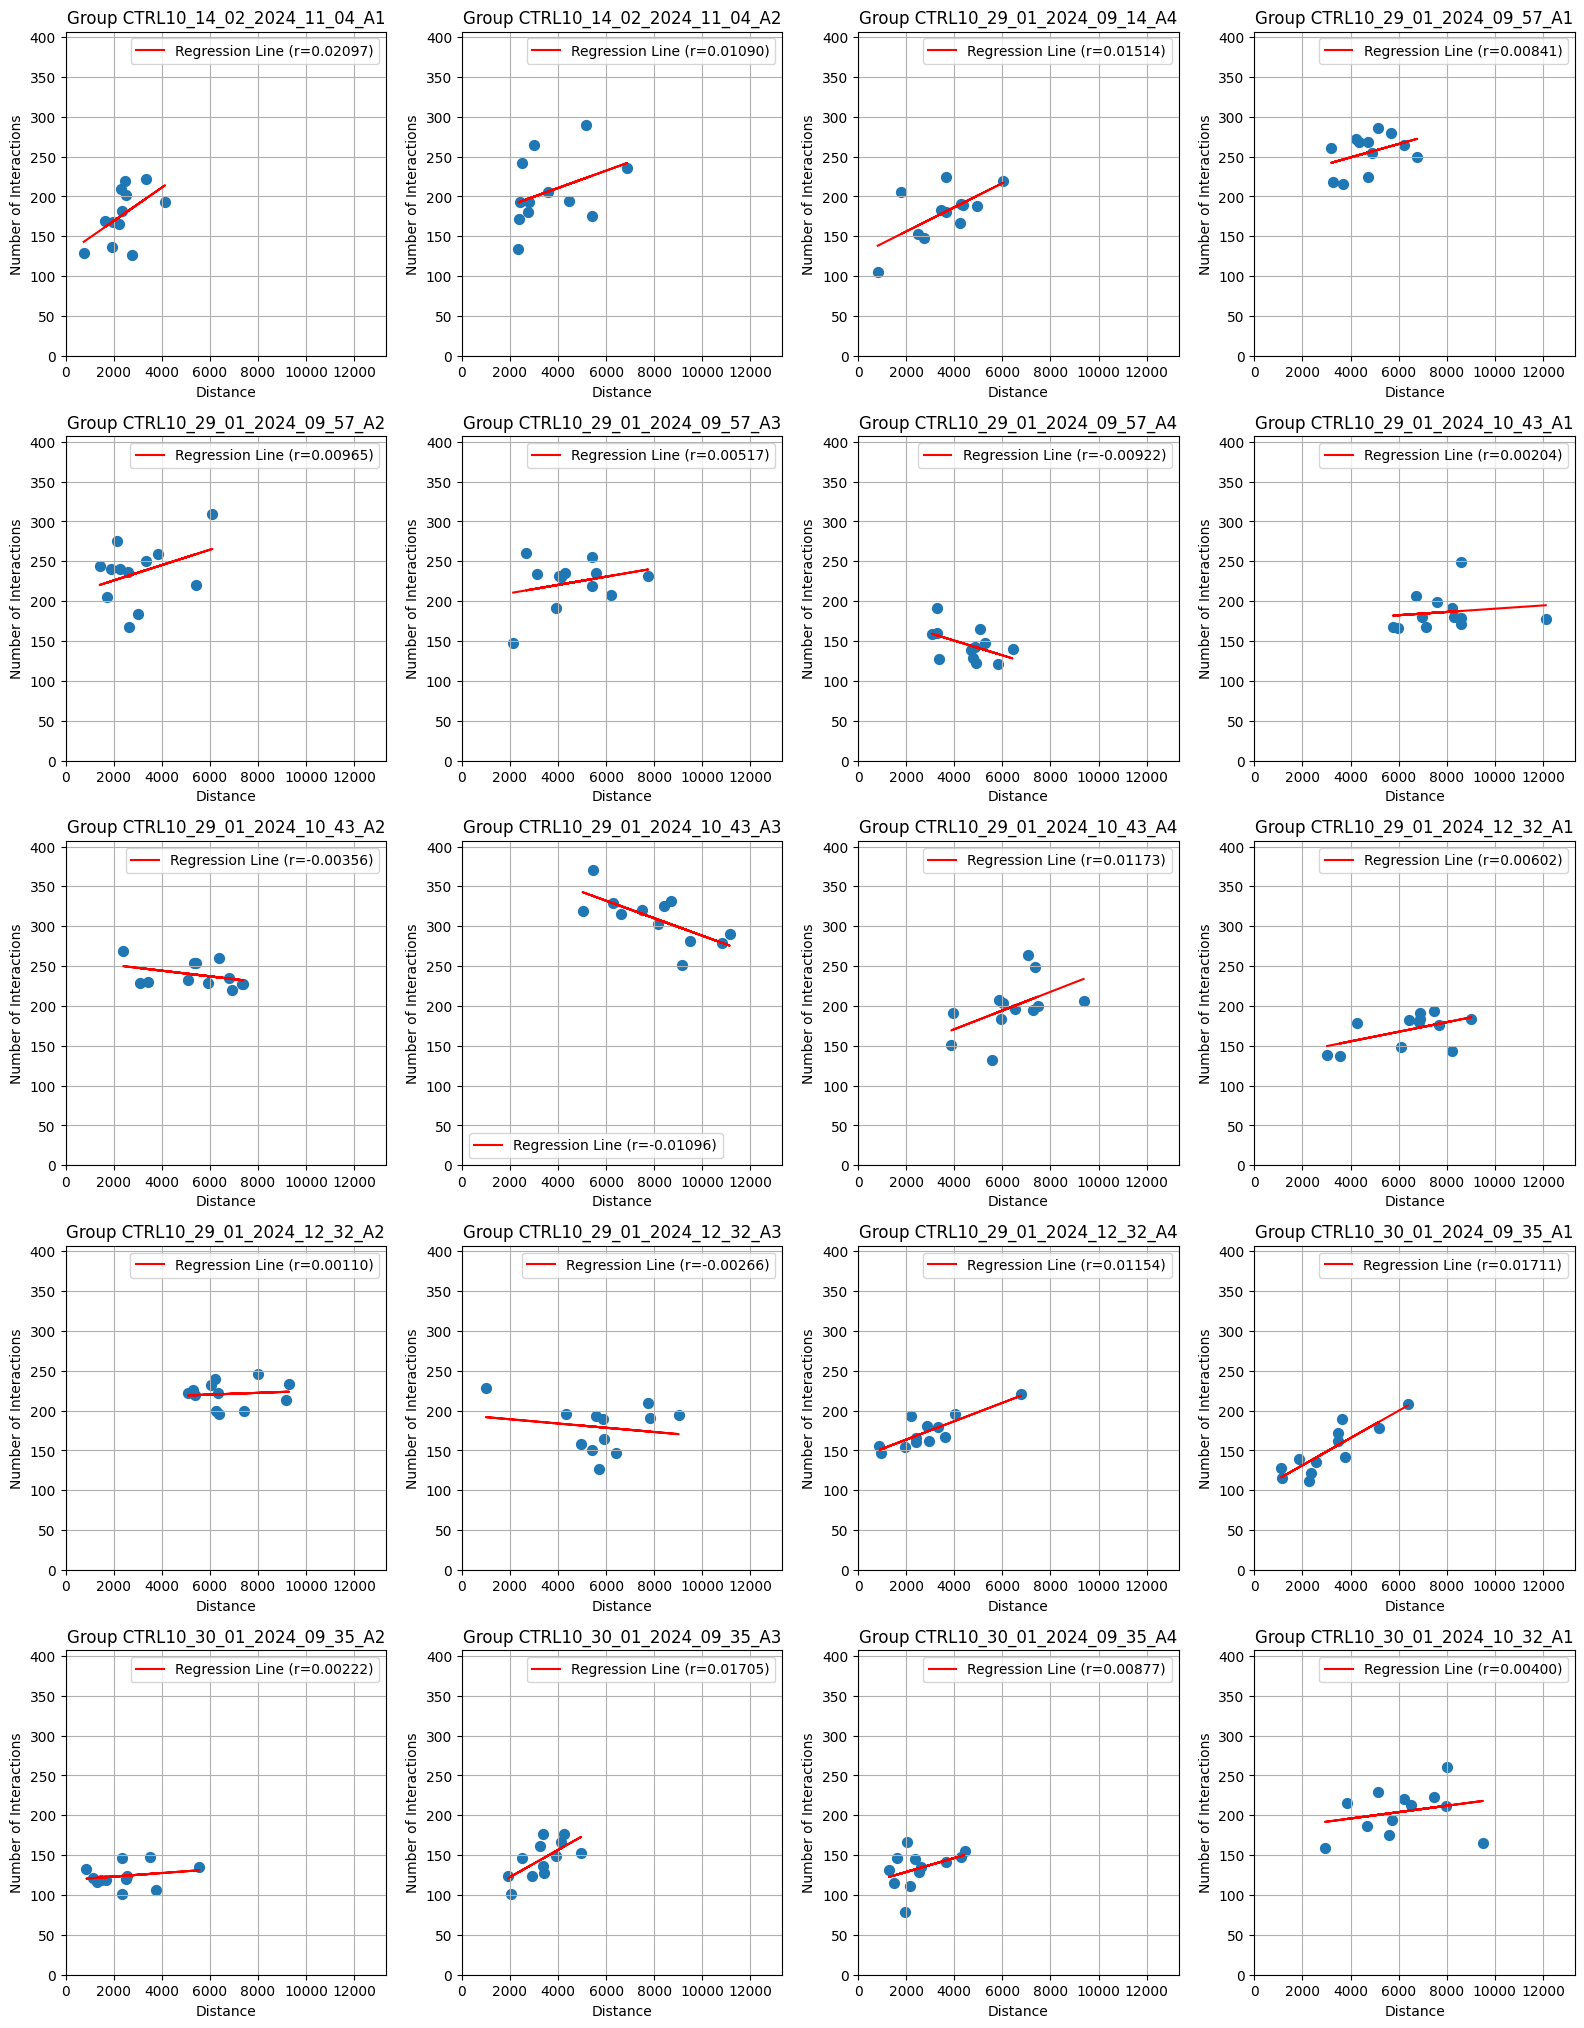

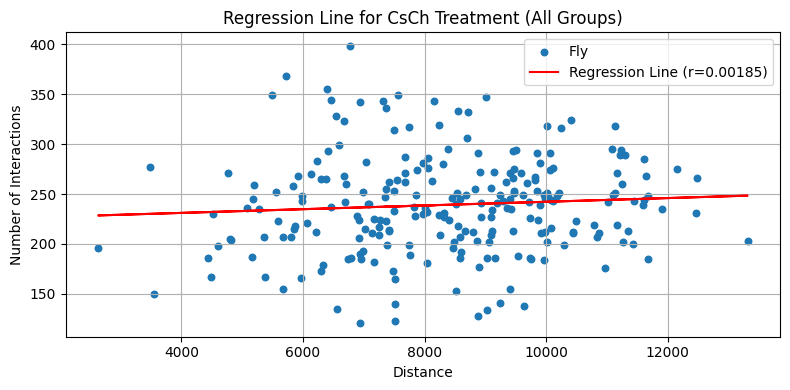

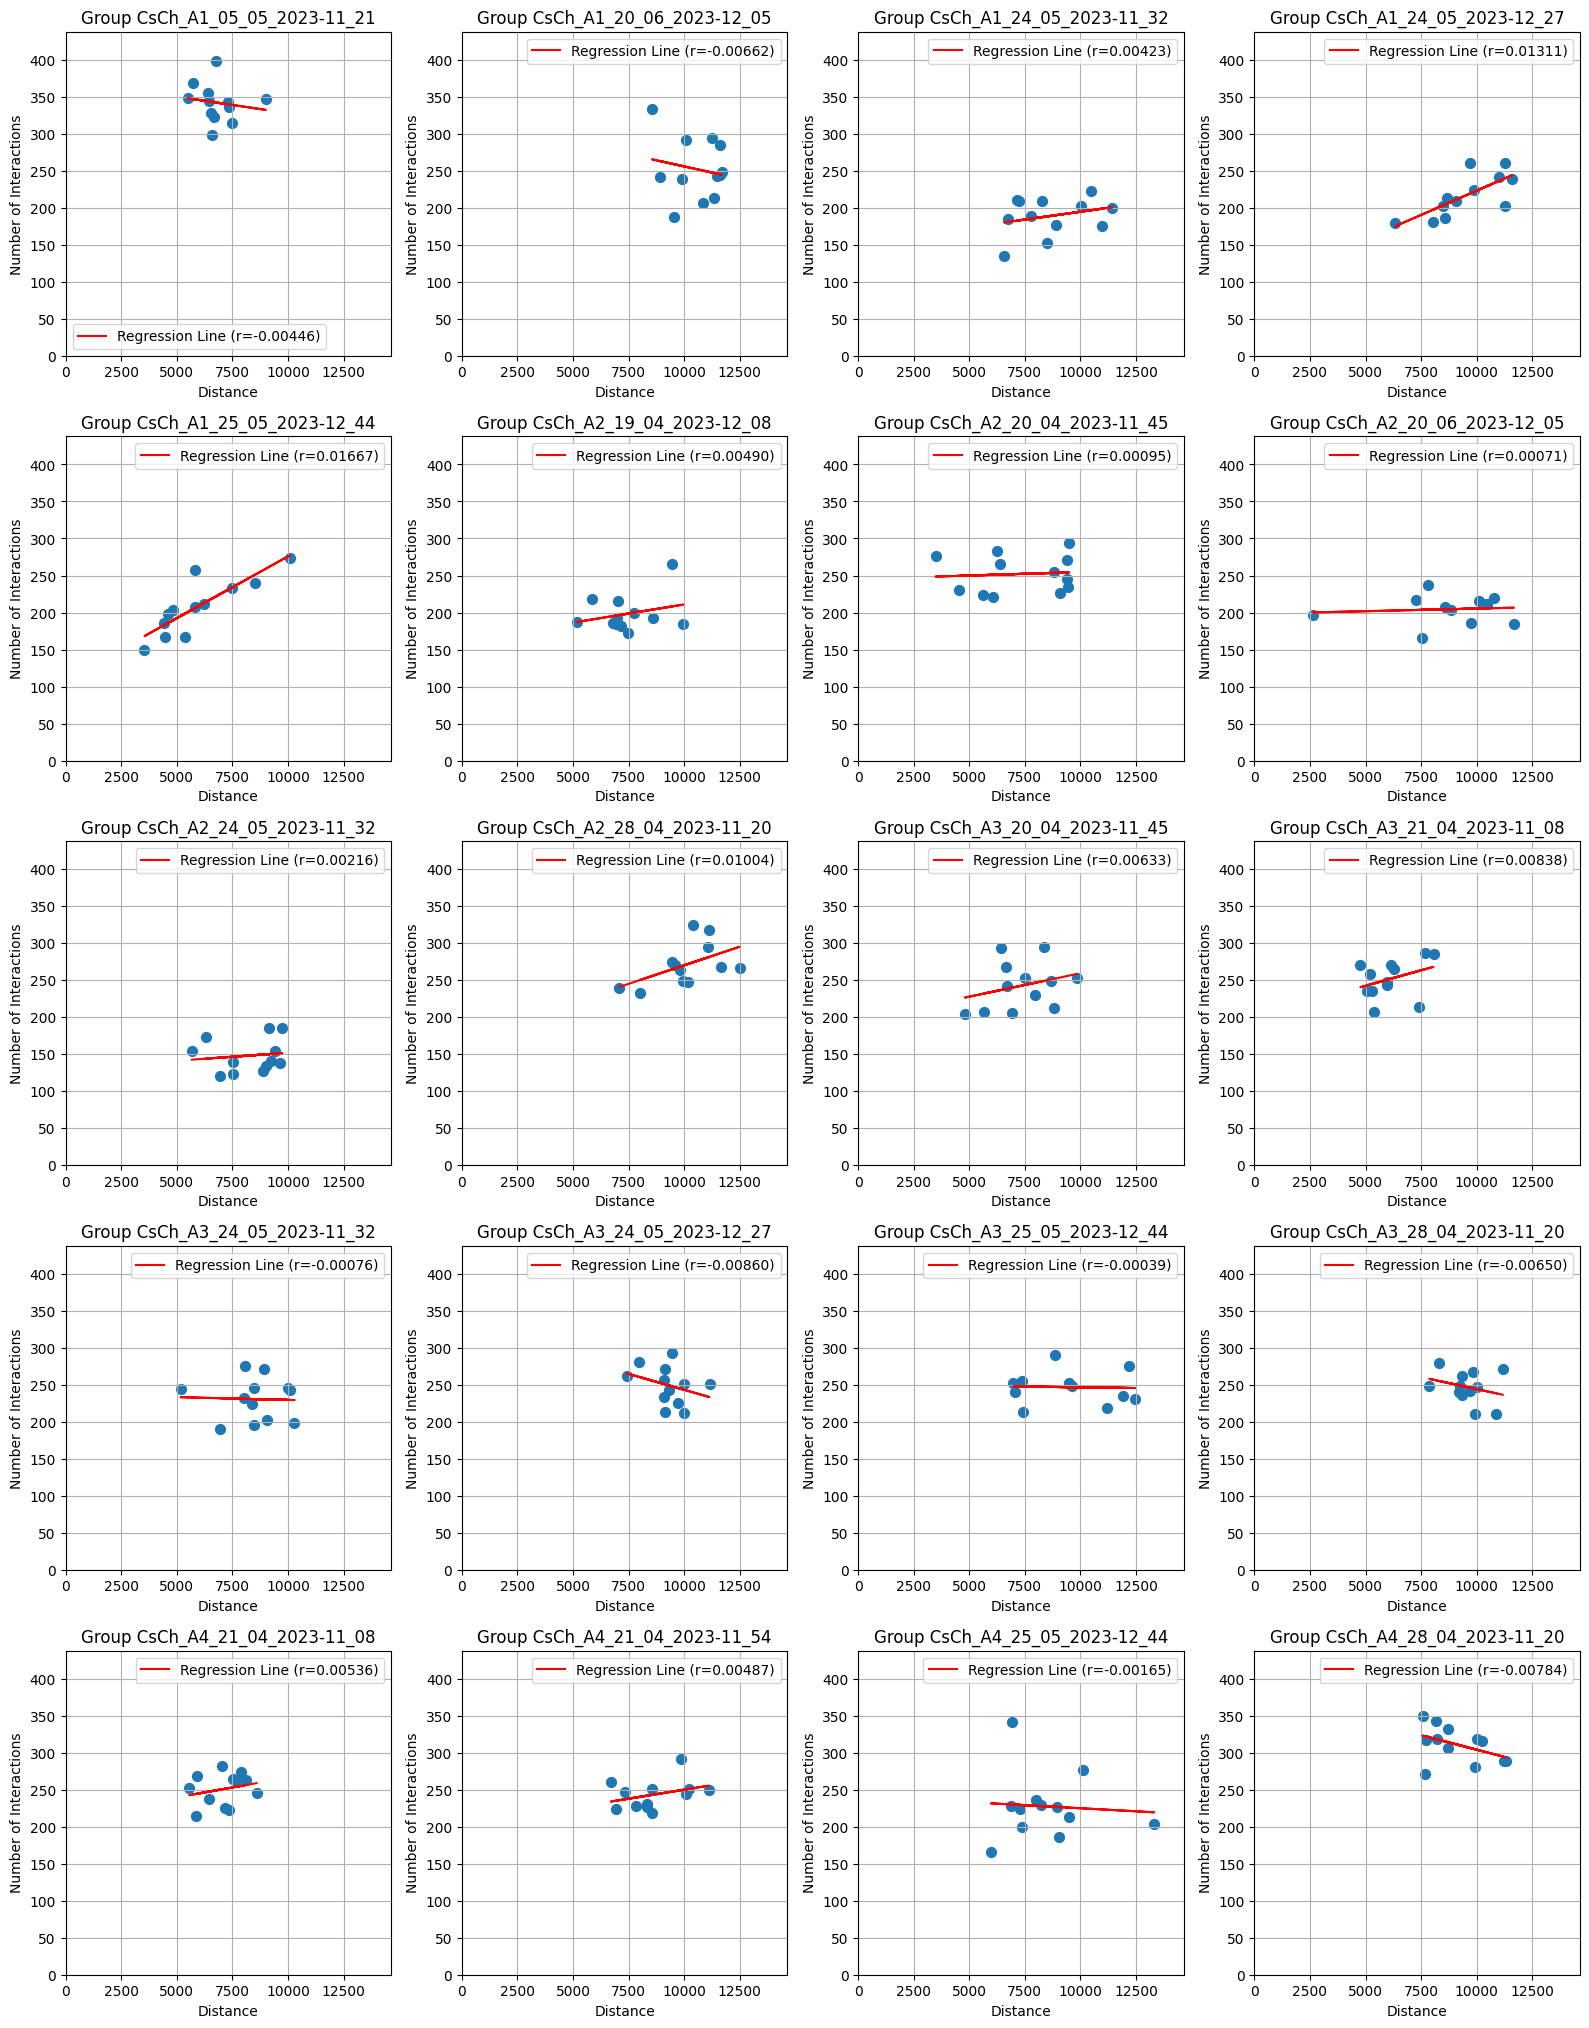

In [1]:
##! TODO add saveimage to report folder

import os, sys
from src import settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.utils import fileio

config = fileio.get_config(settings.CONFIG_NAME)

OUTPUT_DIR = os.path.join(settings.REPORTS_DIR, "figures", "distance_interaction_comparison")
os.makedirs(OUTPUT_DIR, exist_ok=True)

TIME_WINDOW = config["TIME_WINDOW"]

for TREATMENT in config["TREATMENTS"]:
    INPUT_PATH = os.path.join(settings.RESULTS_DIR, "distances_traveled")
    treatments_distances = fileio.load_multiple_folders(INPUT_PATH)
    treatments_distances = {key: value for key, value in treatments_distances.items() if key in config["TREATMENTS"]}

    INPUT_PATH = os.path.join(settings.OUTPUT_DIR, "1_0_find_interactions")
    treatments_interactions = fileio.load_multiple_folders(INPUT_PATH)
    treatments_interactions = {
        key: value for key, value in treatments_interactions.items() if key in config["TREATMENTS"]
    }

    treatment_dataframes = []
    for treatment_distance_key, treatment_interactions_key in zip(
        treatments_distances.keys(), treatments_interactions.keys()
    ):
        treatment_distance_path = treatments_distances[treatment_distance_key]
        treatment_interaction_path = treatments_interactions[treatment_interactions_key]

        distance_groups = fileio.load_files_from_folder(treatment_distance_path)
        interaction_groups = fileio.load_files_from_folder(treatment_interaction_path)

        group_dataframes = []
        for distance_tuple, interaction_tuple in zip(distance_groups.items(), interaction_groups.items()):

            distance_group_name, distance_group_path = distance_tuple
            interaction_group_name, interaction_group_path = interaction_tuple

            if distance_group_name != interaction_group_name:
                sys.exit("Group missmatch!")

            df_distance = pd.read_csv(distance_group_path, index_col=0)
            df_distance["Snapshot"] = (df_distance.index / config["FPS"] / TIME_WINDOW).astype(int) + 1

            df_distance = df_distance.melt(id_vars=["Snapshot"], var_name="Fly", value_name="Distance")
            df_distance = df_distance.groupby(["Snapshot", "Fly"]).sum().reset_index()

            df_interaction = pd.read_csv(interaction_group_path, usecols=["node_1", "start_of_interaction"])
            df_interaction["Snapshot"] = (df_interaction.start_of_interaction / config["FPS"] / TIME_WINDOW).astype(
                int
            ) + 1
            df_interaction = (
                df_interaction.groupby(["Snapshot", "node_1"]).size().reset_index(name="Number_of_interactions")
            )
            df_interaction.columns = ["Snapshot", "Fly", "Number_of_interactions"]

            merged_df = pd.merge(df_distance, df_interaction, on=["Snapshot", "Fly"], how="outer")
            merged_df[merged_df.isna().any(axis=1)]
            merged_df.fillna(0, inplace=True)

            merged_df["Group"] = distance_group_name.replace(".csv", "")
            merged_df.set_index("Snapshot", inplace=True)
            merged_df.set_index("Fly", append=True, inplace=True)
            merged_df.set_index("Group", append=True, inplace=True)
            merged_df["Treatment"] = treatment_distance_key
            merged_df.set_index("Treatment", append=True, inplace=True)
            merged_df = merged_df.reorder_levels(["Treatment", "Group", "Snapshot", "Fly"])

            treatment_dataframes.append(merged_df)

    df = pd.concat(treatment_dataframes)
    df = df.loc[df.index.get_level_values("Treatment") == TREATMENT]

    grouped_df = df.groupby(["Group", "Fly"]).agg({"Distance": "sum", "Number_of_interactions": "sum"}).reset_index()

    plt.figure(figsize=(8, 4))
    plt.scatter(grouped_df["Distance"], grouped_df["Number_of_interactions"], label="Fly", s=22)

    z = np.polyfit(grouped_df["Distance"], grouped_df["Number_of_interactions"], 1)
    p = np.poly1d(z)

    plt.plot(grouped_df["Distance"], p(grouped_df["Distance"]), "r-", label=f"Regression Line (r={z[0]:.5f})")
    plt.xlabel("Distance")
    plt.ylabel("Number of Interactions")
    plt.title(f"Regression Line for {TREATMENT} Treatment (All Groups)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    save_path = os.path.join(OUTPUT_DIR, f"{TREATMENT}_together.png")
    plt.savefig(save_path)

    plt.show()

    grouped_df = df.groupby(["Group", "Fly"]).agg({"Distance": "sum", "Number_of_interactions": "sum"}).reset_index()
    groups = grouped_df["Group"].unique()

    fig, axs = plt.subplots(len(groups) // 4 + 1, 4, figsize=(16, 4 * (len(groups) // 4 + 1)))
    fig.subplots_adjust(hspace=0.5)
    for idx, group in enumerate(groups):
        row = idx // 4
        col = idx % 4
        ax = axs[row, col]
        group_data = grouped_df[grouped_df["Group"] == group]

        ax.scatter(group_data["Distance"], group_data["Number_of_interactions"], marker="o", s=50)

        z = np.polyfit(group_data["Distance"], group_data["Number_of_interactions"], 1)
        p = np.poly1d(z)
        ax.plot(group_data["Distance"], p(group_data["Distance"]), "r-", label=f"Regression Line (r={z[0]:.5f})")

        ax.set_xlim(0, grouped_df["Distance"].max() * 1.1)
        ax.set_ylim(0, grouped_df["Number_of_interactions"].max() * 1.1)

        ax.set_xlabel("Distance")
        ax.set_ylabel("Number of Interactions")
        ax.set_title(f"Group {group}")
        ax.grid(True)
        ax.legend()

    for ax in axs.flatten():
        if not ax.has_data():
            fig.delaxes(ax)

    plt.tight_layout()

    save_path = os.path.join(OUTPUT_DIR, f"{TREATMENT}_groups.png")
    plt.savefig(save_path)

    plt.show()